In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()
api.competition_download_file('time-series-classification-part-1','ETTh1_without_missing.csv')

... resuming from 771105 bytes (1 bytes left) ...


100%|██████████| 753k/753k [00:00<00:00, 61.7B/s]

In [2]:
import pandas as pd

df = pd.read_csv('ETTh1_without_missing.csv')
df['date'] = pd.to_datetime(df['date'])
df


c:\Users\Nassim\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,Id,date,OT
0,0,2016-07-01 00:00:00,30.531000
1,1,2016-07-01 01:00:00,27.787001
2,2,2016-07-01 02:00:00,27.787001
3,3,2016-07-01 03:00:00,25.044001
4,4,2016-07-01 04:00:00,21.948000
...,...,...,...
17315,17315,2018-06-22 11:00:00,6.753000
17316,17316,2018-06-22 12:00:00,3.658000
17317,17317,2018-06-22 13:00:00,3.658000
17318,17318,2018-06-22 14:00:00,4.150000


In [3]:
import numpy as np

# Trouver la dernière date dans le dataframe
derniere_date = df['date'].iloc[-1]
dernier_id = df['Id'].iloc[-1]
# Créer une liste de 100 nouvelles dates à partir de la dernière date
nouvelles_dates = pd.date_range(start=derniere_date, periods=100, freq='H').tolist()

# Créer une liste de 100 nouveaux ID à partir du dernier ID
nouveaux_ids = range(dernier_id + 1, dernier_id + 101)

# Créer un dataframe temporaire avec les nouvelles dates, les nouveaux IDs et les valeurs NaN pour la colonne 'OT'
df_nouvelles_dates = pd.DataFrame({'Id': nouveaux_ids, 'date': nouvelles_dates, 'OT': np.nan})
# Concaténer le dataframe temporaire avec le dataframe existant
# df = pd.concat([df, df_nouvelles_dates], ignore_index=True)

# Afficher le dataframe avec les nouvelles dates ajoutées
df_nouvelles_dates


C:\Users\Nassim\AppData\Local\Temp\ipykernel_22552\526410066.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  nouvelles_dates = pd.date_range(start=derniere_date, periods=100, freq='H').tolist()


,Id,date,OT
0,17320,2018-06-22 15:00:00,NaN
1,17321,2018-06-22 16:00:00,NaN
2,17322,2018-06-22 17:00:00,NaN
3,17323,2018-06-22 18:00:00,NaN
4,17324,2018-06-22 19:00:00,NaN
...,...,...,...
95,17415,2018-06-26 14:00:00,NaN
96,17416,2018-06-26 15:00:00,NaN
97,17417,2018-06-26 16:00:00,NaN
98,17418,2018-06-26 17:00:00,NaN


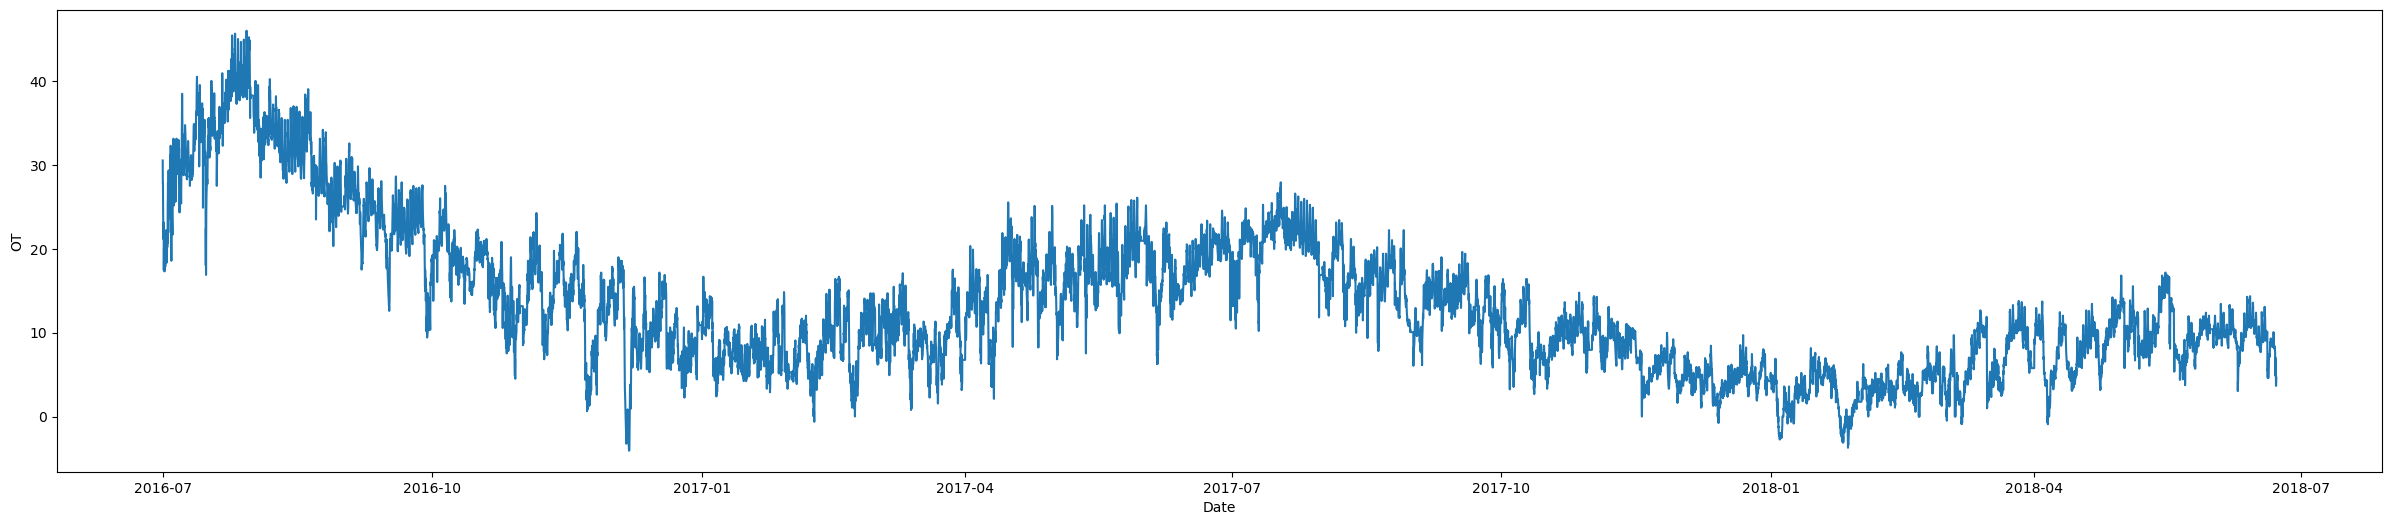

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 6))
sns.lineplot(data=df[['date', 'OT']], x='date', y='OT', legend=False)
plt.xlabel('Date')
plt.ylabel('OT')
plt.title(f"")
# plt.gca().invert_yaxis()
plt.show()

In [20]:
df = df.loc[df['Id'] > 5000]

Empty DataFrame
Columns: [Id, date, OT, timestamp]
Index: []


In [38]:
from sklearn.model_selection import train_test_split
from datetime import datetime
import numpy as np
import tensorflow as tf

df['OT'] = df['OT'].astype('float32')
df['Id'] = df['Id'].astype('int32')
df.dropna(inplace=True)
# Extract the targets (OT values) from the data
targets = df['OT'].values
# print(targets)
# Stack the years, months, days, and hours into a numpy array

reference_date = pd.Timestamp("1970-01-01")
input = (df['date'] - reference_date).dt.total_seconds()/(10**10)
print(input)

# Split the data into training and testing sets
# 80% of the data will be used for training and 20% for testing
# Data is split randomly, with random_state=42 to ensure reproducibility
X_train, X_test, y_train, y_test = train_test_split(input, targets, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(np.array(X_train), np.array(y_train), test_size=0.2)
print(X_train)
# Create TensorFlow datasets from arrays
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

batch_size_value = 64
# Shuffle and batch the training data
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size_value)

# Batch the validation and test data
val_dataset = val_dataset.batch(batch_size_value)
test_dataset = test_dataset.batch(batch_size_value)

# Affichage des tailles des ensembles d'entraînement et de test
print("Train set length :", len(X_train), "samples")
print("Validation set length :", len(X_val), "samples")
print("Test set length :", len(X_test), "samples")
print("Total :", len(X_train)+len(X_test)+len(X_val), "samples")

<class 'pandas.core.series.Series'>
[0.15019632 0.14966388 0.15217992 ... 0.15059664 0.15048432 0.15045408]
Train set length : 7884 samples
Validation set length : 1971 samples
Test set length : 2464 samples
Total : 12319 samples


In [7]:
import tensorflow as tf
# Model creation
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=128, activation='relu', input_shape=(1,)),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=1)  
])

# Compilation
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Training
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, np.array(y_val)))

# Evaluation
loss, mae = model.evaluate(X_test, np.array(y_test))
print("Test loss :", loss)
print("Test MAE :", mae)




Epoch 1/50


247/247 [==============================] - 3s 5ms/step - loss: 64.0533 - mae: 6.3888 - val_loss: 36.1009 - val_mae: 5.0334
Epoch 2/50
247/247 [==============================] - 1s 4ms/step - loss: 36.1535 - mae: 4.9627 - val_loss: 35.5679 - val_mae: 4.9573
Epoch 3/50
247/247 [==============================] - 1s 3ms/step - loss: 36.1381 - mae: 4.9578 - val_loss: 35.4188 - val_mae: 4.9220
Epoch 4/50
247/247 [==============================] - 1s 3ms/step - loss: 36.0926 - mae: 4.9549 - val_loss: 35.4152 - val_mae: 4.8973
Epoch 5/50
247/247 [==============================] - 1s 3ms/step - loss: 36.1335 - mae: 4.9582 - val_loss: 35.4781 - val_mae: 4.9397
Epoch 6/50
247/247 [==============================] - 1s 3ms/step - loss: 36.1446 - mae: 4.9578 - val_loss: 35.3986 - val_mae: 4.9151
Epoch 7/50
247/247 [==============================] - 1s 3ms/step - loss: 36.1258 - mae: 4.9585 - val_loss: 35.4766 - val_mae: 4.8874
Epoch 8/50
247/247 [==============================] - 1s 3

In [8]:
def preprocess_next_date(date, hour):
    
    years = int(date.split("-")[0])
    months = int(date.split("-")[1])
    days = int(date.split("-")[2])

    return np.array([[years, months, days, hour]])

In [44]:
import csv

def predict_next_100_values(filename):
    fields = ["Id", "OT"]

    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(fields)
        
        for i in range(100):
            csv_line = []

            # Obtenir la valeur de la date pour cet ID spécifique
            date = df_nouvelles_dates['date'].iloc[i]
            
            # Convertir le Timestamp en objet datetime
            date_object = date.to_pydatetime()

            # Convertir la date en secondes depuis l'époque (01/01/1970)
            seconds = int(date_object.timestamp())
            # Normaliser les valeurs en secondes
            normalized_seconds = seconds / 10**10
            # Transformer normalized_seconds en un tableau numpy 2D
            normalized_seconds_array = np.array([[normalized_seconds]])

            # Utiliser chaque valeur normalisée en secondes pour prédire la valeur OT correspondante
            new_value_prediction = model.predict(normalized_seconds_array)
    
            csv_line = [i, float(new_value_prediction)]
            writer.writerow(csv_line)
    print(f"CSV file '{filename}' successfully created.")

filename = "neural_network_prediction.csv"
predict_next_100_values(filename)


1/1 [==============================] - 0s 22ms/step
CSV file 'neural_network_prediction.csv' successfully created.
